# Experiment Results Visualization

Unified visualization for SKTR and KARI experiments across datasets and models.

In [13]:
import os
import math
from pathlib import Path
from typing import Optional, List, Dict, Literal

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid', context='notebook', palette='deep')

## Configuration

In [14]:
# Base paths
SKTR_RESULTS_BASE = Path.home() / 'sktr_for_long_traces' / 'results'
KARI_RESULTS_BASE = Path.home() / 'kari' / 'results'

# Valid options
DATASETS = ['50salads', 'gtea', 'breakfast']
MODELS = ['asformer', 'mstcn2']
METHODS = ['sktr', 'kari']

# Metrics to plot
METRICS = ['acc', 'edit', 'f1@10', 'f1@25', 'f1@50']

## Data Loading Functions

In [15]:
def find_sktr_results(dataset: str, model: str) -> Optional[Path]:
    """Find SKTR sweep summary CSV for given dataset and model."""
    # New path structure: results/{dataset}/variant_experiment/{model}/final_experiment/
    pattern = f'{dataset}_{model}_sweep_summary.csv'
    search_path = SKTR_RESULTS_BASE / dataset / 'variant_experiment' / model / 'final_experiment'
    
    if search_path.exists():
        csv_path = search_path / pattern
        if csv_path.exists():
            return csv_path
    
    # Fallback: search recursively
    for path in SKTR_RESULTS_BASE.rglob(pattern):
        return path
    
    return None


def find_kari_results(dataset: str, model: str) -> Optional[Path]:
    """Find KARI sweep summary CSV for given dataset and model."""
    # Path structure: results/experiments_{dataset}_{model}/{dataset}_{model}_sweep_summary.csv
    results_dir = KARI_RESULTS_BASE / f'experiments_{dataset}_{model}'
    csv_path = results_dir / f'{dataset}_{model}_sweep_summary.csv'
    
    if csv_path.exists():
        return csv_path
    return None


def load_results(
    dataset: str,
    model: str,
    method: Literal['sktr', 'kari']
) -> Optional[pd.DataFrame]:
    """
    Load experiment results for a given configuration.
    
    Parameters
    ----------
    dataset : str
        Dataset name: '50salads', 'gtea', or 'breakfast'
    model : str
        Model name: 'asformer' or 'mstcn2'
    method : str
        Method: 'sktr' or 'kari'
    
    Returns
    -------
    pd.DataFrame or None
        DataFrame with columns: n_train_variants, {method}_{metric}, argmax_{metric}
    """
    if method == 'sktr':
        path = find_sktr_results(dataset, model)
    else:
        path = find_kari_results(dataset, model)
    
    if path is None:
        print(f"Results not found for {method}/{dataset}/{model}")
        return None
    
    print(f"Loading: {path}")
    df = pd.read_csv(path)
    
    # Normalize column names
    if 'k' in df.columns and 'n_train_variants' not in df.columns:
        df['n_train_variants'] = df['k']
    
    return df


def list_available_results() -> pd.DataFrame:
    """List all available experiment results."""
    rows = []
    for dataset in DATASETS:
        for model in MODELS:
            for method in METHODS:
                if method == 'sktr':
                    path = find_sktr_results(dataset, model)
                else:
                    path = find_kari_results(dataset, model)
                rows.append({
                    'dataset': dataset,
                    'model': model,
                    'method': method,
                    'available': path is not None,
                    'path': str(path) if path else '-'
                })
    return pd.DataFrame(rows)

In [16]:
# Check what's available
available = list_available_results()
print("Available Results:")
print(available.to_string(index=False))

Available Results:
  dataset    model method  available                                                                                                                                  path
 50salads asformer   sktr      False                                                                                                                                     -
 50salads asformer   kari      False                                                                                                                                     -
 50salads   mstcn2   sktr      False                                                                                                                                     -
 50salads   mstcn2   kari      False                                                                                                                                     -
     gtea asformer   sktr       True /home/dsi/eli-bogdanov/sktr_for_long_traces/results/gtea/variant_experiment/asformer/fina

## Plotting Functions

In [17]:
def plot_single_experiment(
    df: pd.DataFrame,
    method: str,
    title: str = '',
    figsize: tuple = (22, 12),
    save_path: Optional[str] = None
):
    """
    Plot results for a single experiment (method vs argmax baseline).
    Uses 2x3 grid: 5 metrics + legend.
    """
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()
    
    metrics_config = [
        ('acc', 'Accuracy'),
        ('edit', 'Edit Score'),
        ('f1@10', 'F1@10'),
        ('f1@25', 'F1@25'),
        ('f1@50', 'F1@50'),
    ]
    
    method_styles = {
        method: {'marker': 'o', 'linewidth': 2.5, 'markersize': 8},
        'argmax': {'marker': 's', 'linewidth': 2, 'markersize': 7, 'linestyle': '--'},
    }
    
    x_col = 'n_train_variants'
    
    # Compute y-axis limits
    plot_cols = [f'{method}_{m}' for m, _ in metrics_config] + [f'argmax_{m}' for m, _ in metrics_config]
    plot_cols = [c for c in plot_cols if c in df.columns]
    if plot_cols:
        y_min = df[plot_cols].min().min()
        y_max = df[plot_cols].max().max()
        y_lower = math.floor(y_min / 10) * 10
        y_upper = max(y_max, 80)
        tick_start = min(y_lower, 50)
        tick_end = math.ceil(y_upper / 10) * 10
        y_limits = (tick_start, tick_end)
        y_ticks = list(range(int(tick_start), int(tick_end) + 1, 10))
    else:
        y_limits, y_ticks = None, None
    
    for idx, (metric_suffix, metric_title) in enumerate(metrics_config):
        ax = axes[idx]
        for m_name, style in method_styles.items():
            col_name = f'{m_name}_{metric_suffix}'
            if col_name in df.columns:
                label = m_name.upper() if m_name != 'argmax' else 'Argmax'
                sns.lineplot(
                    x=df[x_col], y=df[col_name],
                    ax=ax, label=label, **style
                )
        ax.set_title(metric_title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Number of Training Variants')
        ax.set_ylabel('Score')
        ax.set_xticks(df[x_col].unique())
        if y_limits:
            ax.set_ylim(*y_limits)
        if y_ticks:
            ax.set_yticks(y_ticks)
        ax.legend().remove()
    
    # Legend in 6th subplot
    ax_legend = axes[5]
    ax_legend.axis('off')
    handles, labels = axes[0].get_legend_handles_labels()
    ax_legend.legend(
        handles, labels,
        loc='center', title='Method',
        fontsize=14, title_fontsize=16,
        frameon=True, fancybox=True, shadow=True
    )
    
    if title:
        fig.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()


def plot_method_comparison(
    dataset: str,
    model: str,
    figsize: tuple = (22, 12),
    save_path: Optional[str] = None
):
    """
    Compare SKTR vs KARI for a given dataset and model.
    """
    sktr_df = load_results(dataset, model, 'sktr')
    kari_df = load_results(dataset, model, 'kari')
    
    if sktr_df is None and kari_df is None:
        print(f"No results available for {dataset}/{model}")
        return
    
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()
    
    metrics_config = [
        ('acc', 'Accuracy'),
        ('edit', 'Edit Score'),
        ('f1@10', 'F1@10'),
        ('f1@25', 'F1@25'),
        ('f1@50', 'F1@50'),
    ]
    
    colors = {'sktr': 'tab:blue', 'kari': 'tab:orange', 'argmax': 'tab:gray'}
    
    for idx, (metric_suffix, metric_title) in enumerate(metrics_config):
        ax = axes[idx]
        
        if sktr_df is not None:
            col = f'sktr_{metric_suffix}'
            if col in sktr_df.columns:
                sns.lineplot(
                    x=sktr_df['n_train_variants'], y=sktr_df[col],
                    ax=ax, label='SKTR', color=colors['sktr'],
                    marker='o', linewidth=2.5, markersize=8
                )
            # Argmax from SKTR
            argmax_col = f'argmax_{metric_suffix}'
            if argmax_col in sktr_df.columns:
                sns.lineplot(
                    x=sktr_df['n_train_variants'], y=sktr_df[argmax_col],
                    ax=ax, label='Argmax', color=colors['argmax'],
                    marker='s', linewidth=2, markersize=7, linestyle='--'
                )
        
        if kari_df is not None:
            col = f'kari_{metric_suffix}'
            if col in kari_df.columns:
                sns.lineplot(
                    x=kari_df['n_train_variants'], y=kari_df[col],
                    ax=ax, label='KARI', color=colors['kari'],
                    marker='^', linewidth=2.5, markersize=8
                )
        
        ax.set_title(metric_title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Number of Training Variants')
        ax.set_ylabel('Score')
        ax.legend().remove()
    
    # Legend
    ax_legend = axes[5]
    ax_legend.axis('off')
    handles, labels = axes[0].get_legend_handles_labels()
    ax_legend.legend(
        handles, labels,
        loc='center', title='Method',
        fontsize=14, title_fontsize=16,
        frameon=True, fancybox=True, shadow=True
    )
    
    title = f'{dataset.upper()} / {model.upper()} - SKTR vs KARI'
    fig.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

## Quick Visualization

Use `visualize()` for one-liner plots.

In [18]:
def visualize(
    dataset: str = 'gtea',
    model: str = 'asformer',
    method: Optional[str] = None,
    figsize: tuple = (22, 12),
    save: bool = False
):
    """
    Quick visualization function.
    
    Parameters
    ----------
    dataset : str
        '50salads', 'gtea', or 'breakfast'
    model : str
        'asformer' or 'mstcn2'
    method : str, optional
        'sktr', 'kari', or None for comparison
    figsize : tuple
        Figure size (width, height) in inches
    save : bool
        Save plot to file
    
    Examples
    --------
    >>> visualize('gtea', 'asformer', 'sktr')  # Single method
    >>> visualize('gtea', 'asformer')          # Compare SKTR vs KARI
    >>> visualize('50salads', 'mstcn2', save=True)
    >>> visualize('gtea', 'mstcn2', figsize=(24, 14))  # Larger plot
    """
    save_path = f'{dataset}_{model}_{method or "comparison"}.png' if save else None
    
    if method:
        df = load_results(dataset, model, method)
        if df is not None:
            title = f'{dataset.upper()} / {model.upper()} / {method.upper()}'
            plot_single_experiment(df, method, title=title, figsize=figsize, save_path=save_path)
    else:
        plot_method_comparison(dataset, model, figsize=figsize, save_path=save_path)

## Examples

Loading: /home/dsi/eli-bogdanov/sktr_for_long_traces/results/gtea/variant_experiment/asformer/final_experiment/gtea_asformer_sweep_summary.csv


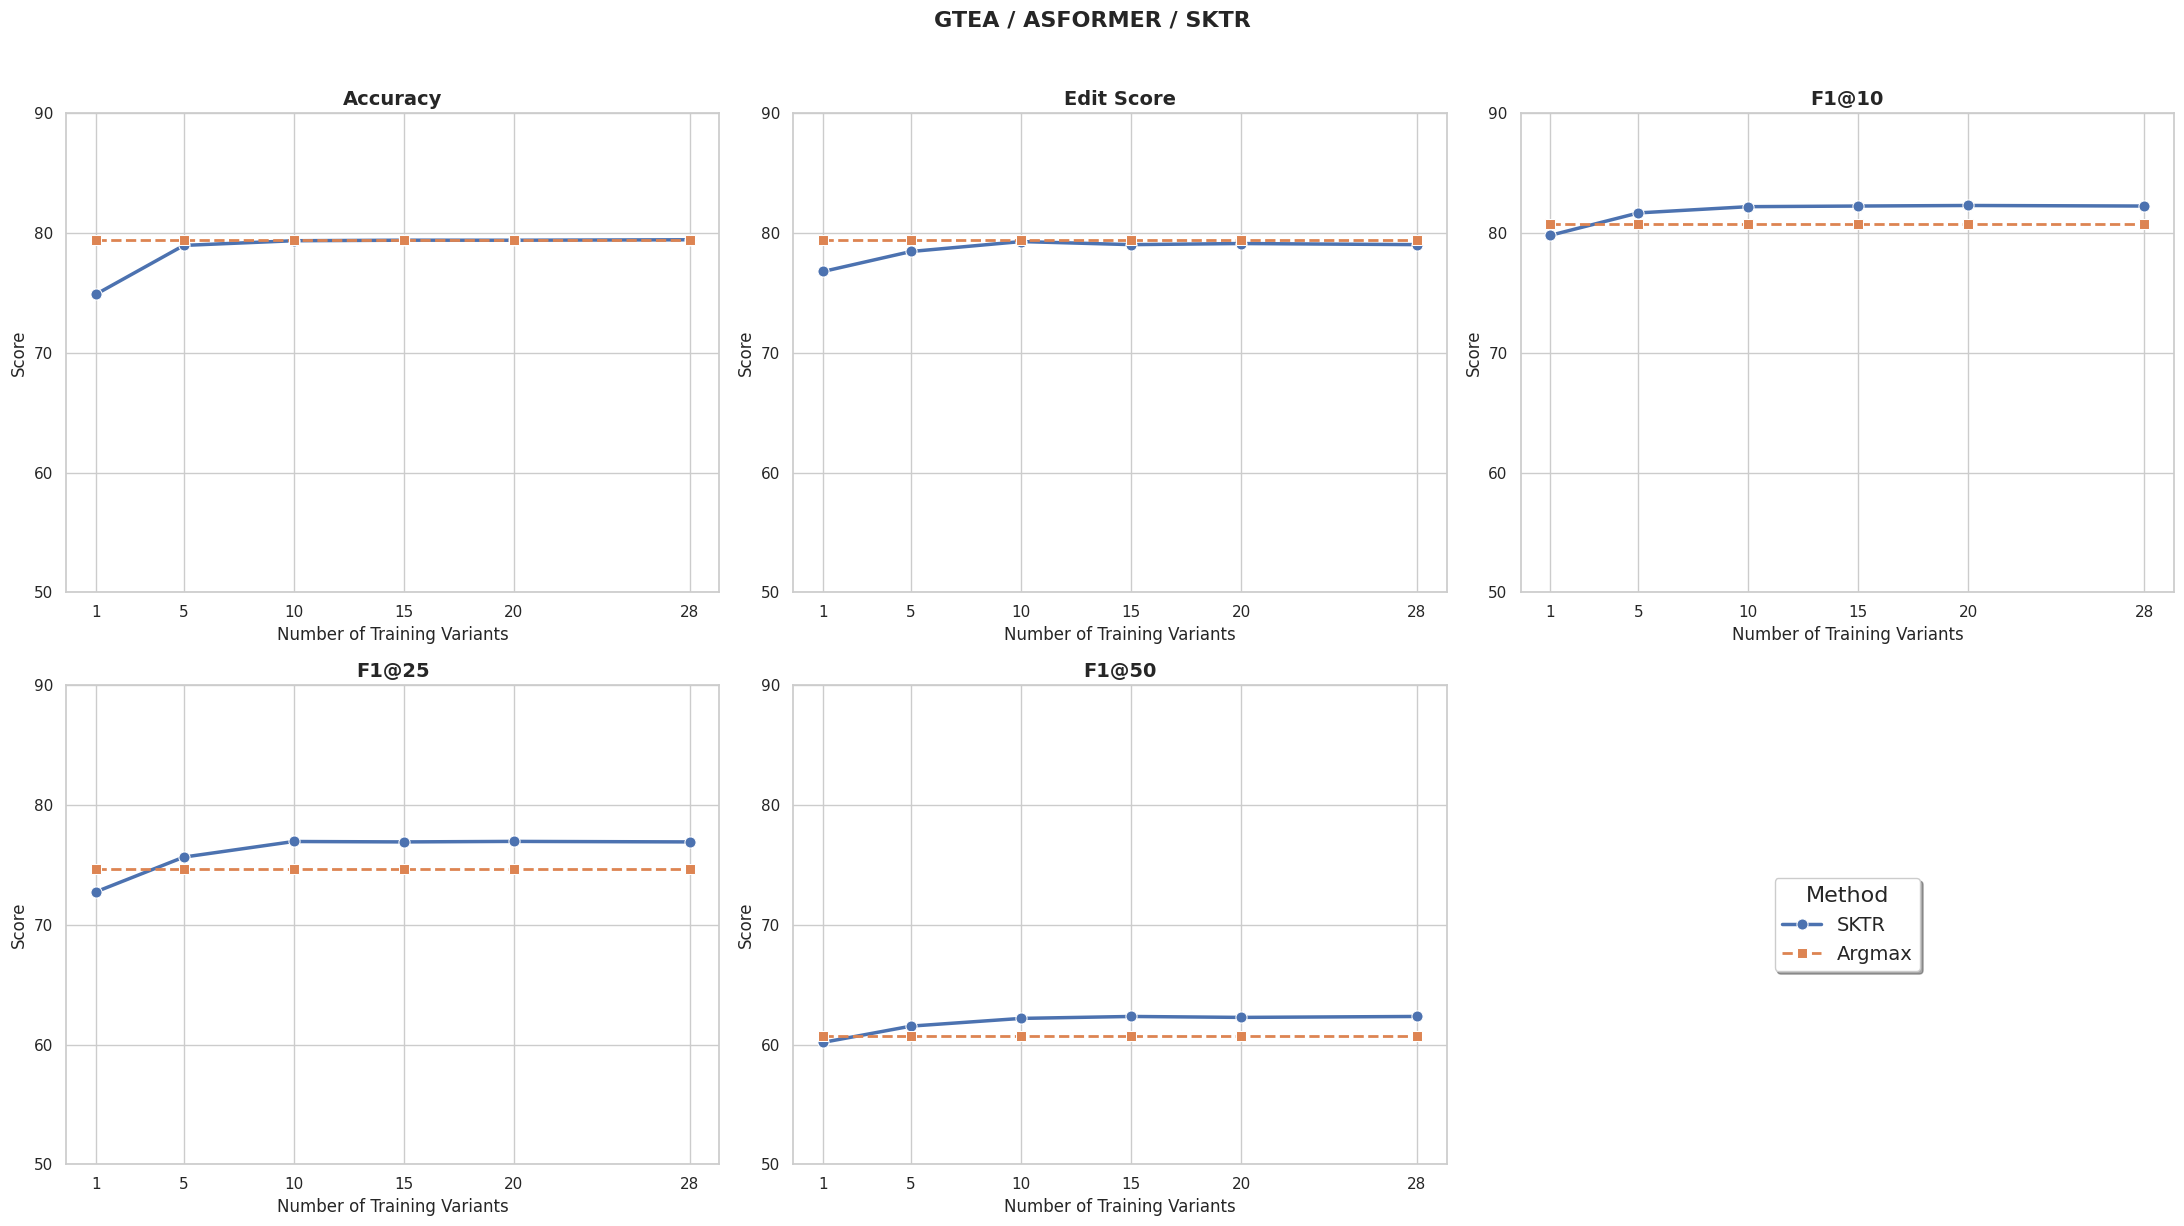

In [19]:
# Single method visualization
visualize('gtea', 'asformer', 'sktr')

Loading: /home/dsi/eli-bogdanov/sktr_for_long_traces/results/gtea/variant_experiment/mstcn2/final_experiment/gtea_mstcn2_sweep_summary.csv


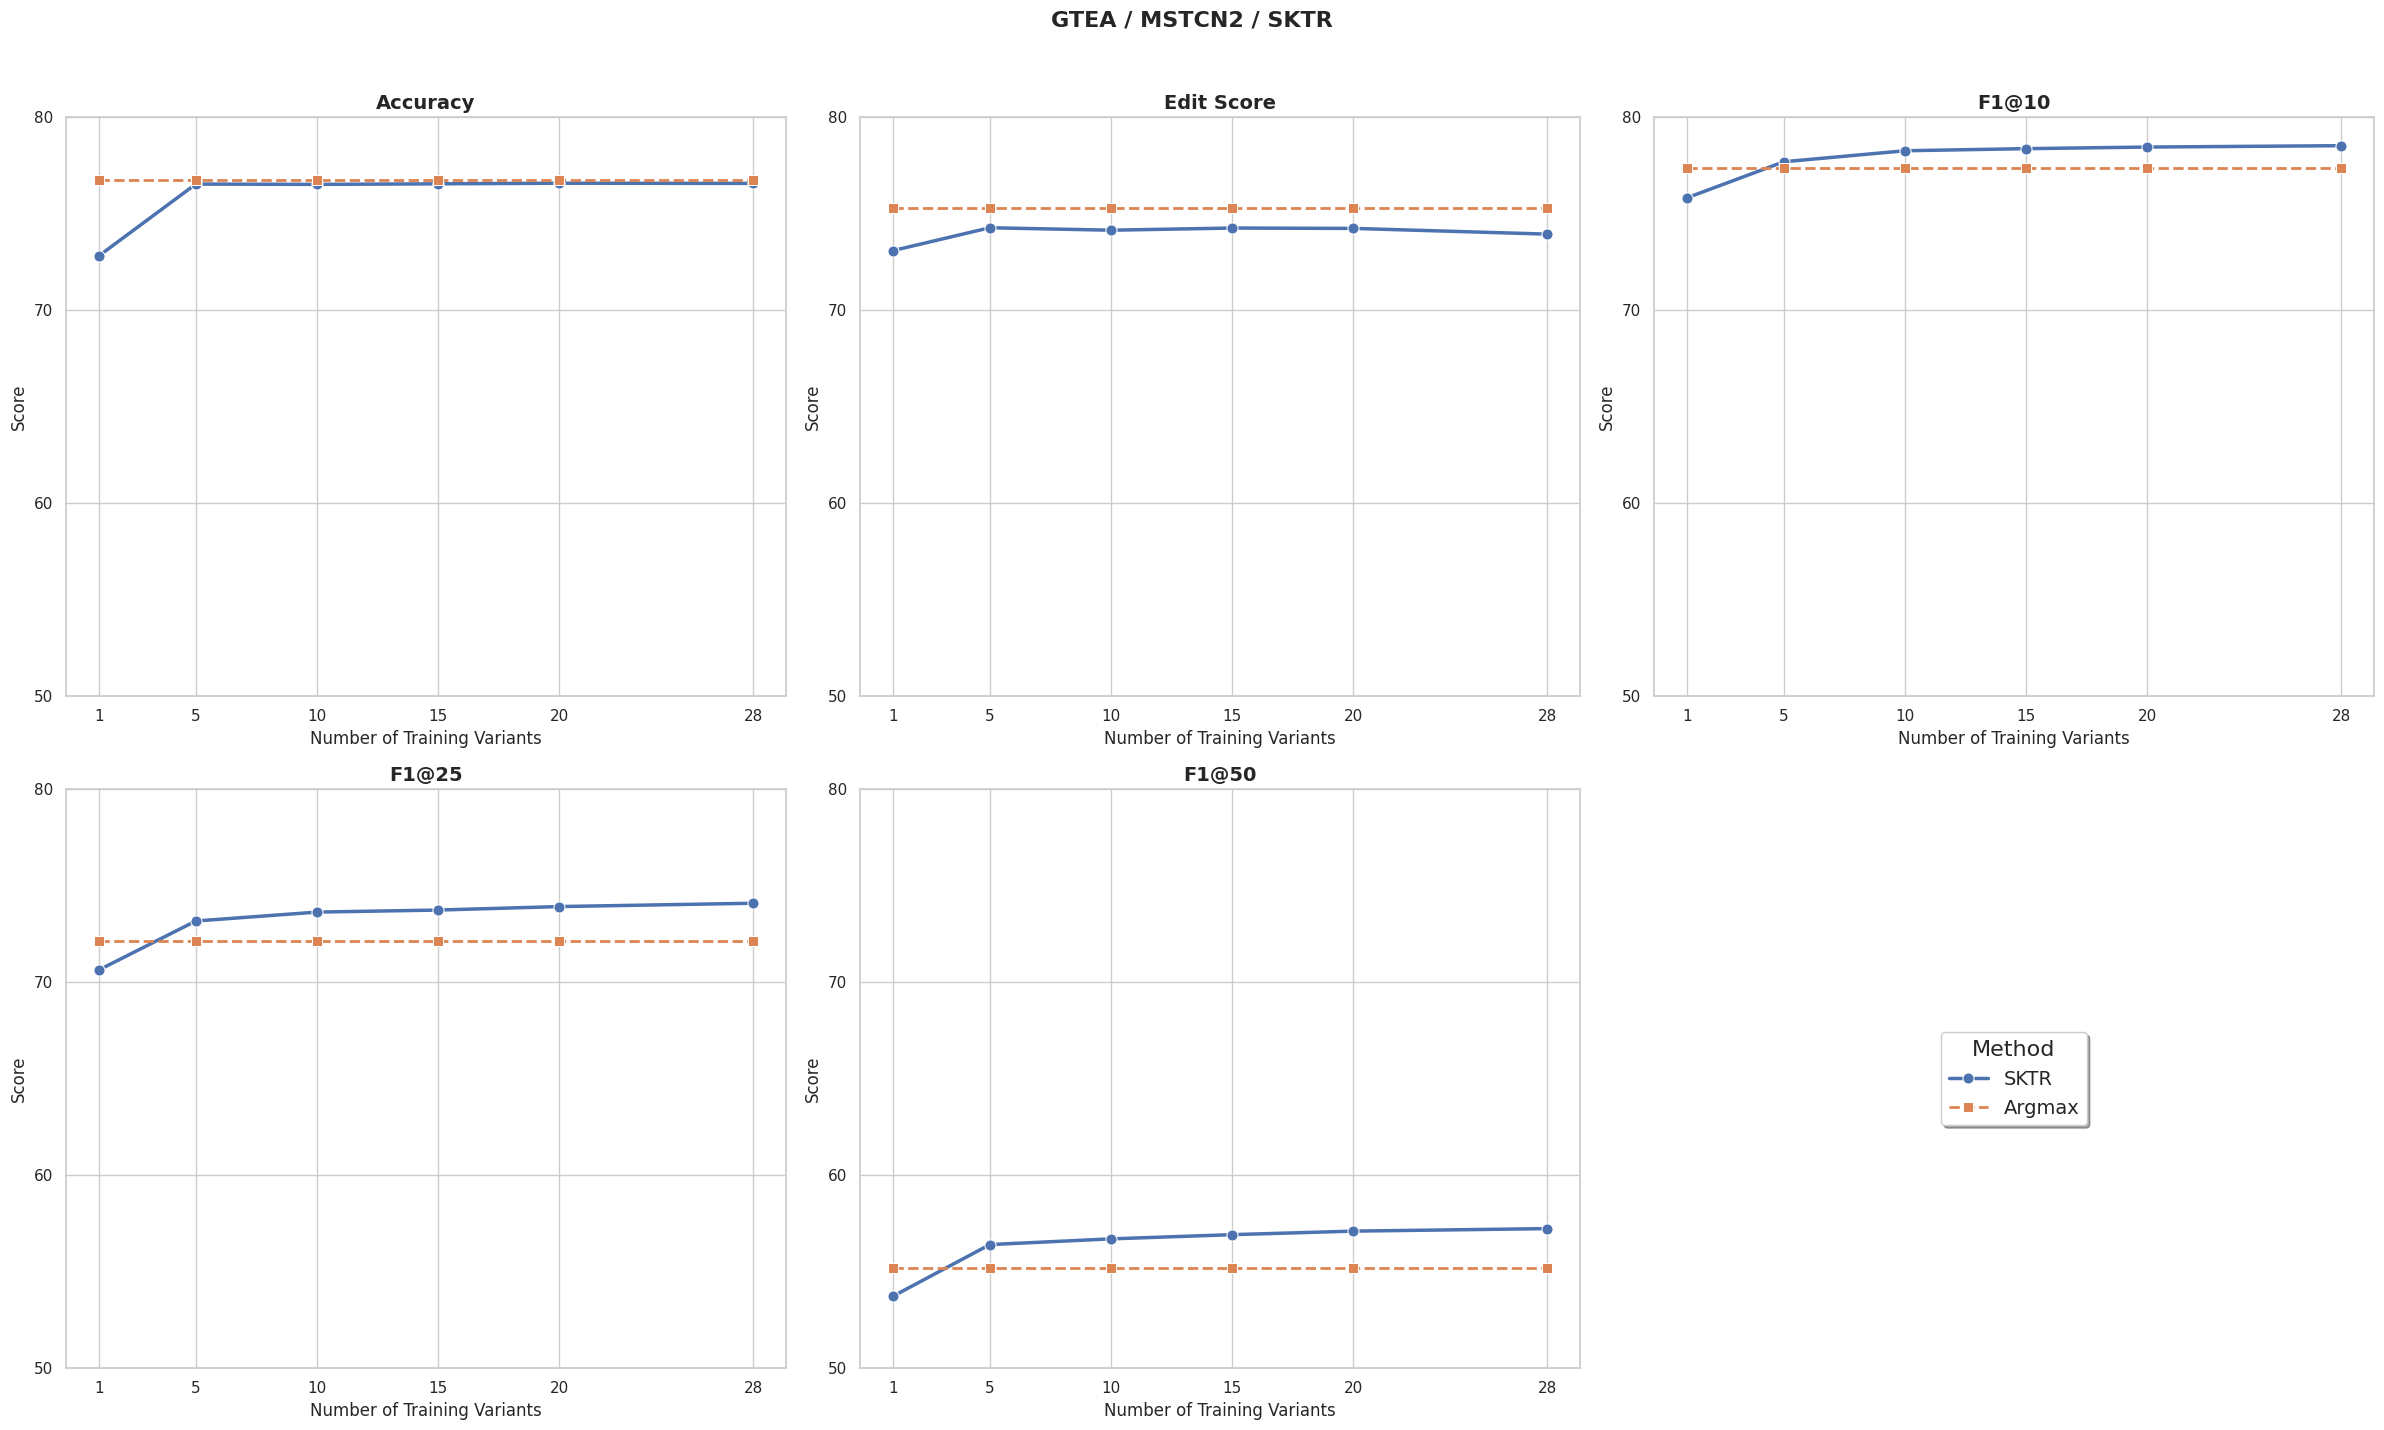

In [22]:
# Compare SKTR vs KARI
visualize('gtea', 'mstcn2', 'sktr', figsize=(24, 14))

In [ ]:
# Load raw data for custom analysis
# df = load_results('50salads', 'asformer', 'kari')
# df.head()

## Summary Table

In [26]:
def get_best_results(
    dataset: str,
    model: str,
    method: str,
    k: Optional[int] = None,
    rank_metrics: List[str] = ['acc', 'edit', 'f1@25']
) -> Optional[Dict]:
    """
    Get best results (or results at specific k) for a configuration.
    
    Parameters
    ----------
    k : int, optional
        Specific k value. If None, selects best by average rank.
    rank_metrics : list
        Metrics to use for ranking. Default: ['acc', 'edit', 'f1@25'] (same as SKTR)
    """
    df = load_results(dataset, model, method)
    if df is None:
        return None
    
    if k is not None:
        row = df[df['n_train_variants'] == k]
        if row.empty:
            return None
        row = row.iloc[0]
    else:
        # Select best by average rank (same as SKTR)
        metric_cols = [f'{method}_{m}' for m in rank_metrics]
        metric_cols = [c for c in metric_cols if c in df.columns]
        
        if not metric_cols:
            return None
        
        # Compute ranks (higher value = better = lower rank number)
        ranks = df[metric_cols].rank(ascending=False, method='average')
        df = df.copy()
        df['avg_rank'] = ranks.mean(axis=1)
        
        # Best = lowest average rank, tie-break by accuracy
        acc_col = f'{method}_acc'
        if acc_col in df.columns:
            row = df.sort_values(['avg_rank', acc_col], ascending=[True, False]).iloc[0]
        else:
            row = df.sort_values('avg_rank', ascending=True).iloc[0]
    
    return {
        'dataset': dataset,
        'model': model,
        'method': method,
        'k': int(row['n_train_variants']),
        'acc': row.get(f'{method}_acc', np.nan),
        'edit': row.get(f'{method}_edit', np.nan),
        'f1@10': row.get(f'{method}_f1@10', np.nan),
        'f1@25': row.get(f'{method}_f1@25', np.nan),
        'f1@50': row.get(f'{method}_f1@50', np.nan),
        'avg_rank': row.get('avg_rank', np.nan) if k is None else np.nan,
    }


def summary_table(
    k: Optional[int] = None,
    rank_metrics: List[str] = ['acc', 'edit', 'f1@25']
) -> pd.DataFrame:
    """
    Generate summary table of all available results.
    
    Parameters
    ----------
    k : int, optional
        Show results at specific k. If None, shows best by average rank.
    rank_metrics : list
        Metrics for ranking. Default: ['acc', 'edit', 'f1@25'] (same as SKTR)
    """
    rows = []
    for dataset in DATASETS:
        for model in MODELS:
            for method in METHODS:
                result = get_best_results(dataset, model, method, k, rank_metrics)
                if result:
                    rows.append(result)
    
    if not rows:
        print("No results available.")
        return pd.DataFrame()
    
    df = pd.DataFrame(rows)
    
    # Reorder columns
    cols = ['dataset', 'model', 'method', 'k']
    if 'avg_rank' in df.columns and k is None:
        cols.append('avg_rank')
    cols.extend(['acc', 'edit', 'f1@10', 'f1@25', 'f1@50'])
    df = df[[c for c in cols if c in df.columns]]
    
    # Format numeric columns
    for col in ['acc', 'edit', 'f1@10', 'f1@25', 'f1@50']:
        if col in df.columns:
            df[col] = df[col].round(2)
    if 'avg_rank' in df.columns:
        df['avg_rank'] = df['avg_rank'].round(2)
    
    return df

In [ ]:
# Show best results across all configurations
summary_table()

Results not found for sktr/50salads/asformer
Results not found for kari/50salads/asformer
Results not found for sktr/50salads/mstcn2
Results not found for kari/50salads/mstcn2
Loading: /home/dsi/eli-bogdanov/sktr_for_long_traces/results/gtea/variant_experiment/asformer/final_experiment/gtea_asformer_sweep_summary.csv
Results not found for kari/gtea/asformer
Loading: /home/dsi/eli-bogdanov/sktr_for_long_traces/results/gtea/variant_experiment/mstcn2/final_experiment/gtea_mstcn2_sweep_summary.csv
Results not found for kari/gtea/mstcn2
Results not found for sktr/breakfast/asformer
Results not found for kari/breakfast/asformer
Results not found for sktr/breakfast/mstcn2
Results not found for kari/breakfast/mstcn2


,dataset,model,method,k,avg_rank,acc,edit,f1@10,f1@25,f1@50
0,gtea,asformer,sktr,20,2.0,79.40,79.13,82.30,76.96,62.27
1,gtea,mstcn2,sktr,20,2.0,76.59,74.24,78.46,73.92,57.11


In [25]:
# Show results at specific k
summary_table(k=10)

Results not found for sktr/50salads/asformer
Results not found for kari/50salads/asformer
Results not found for sktr/50salads/mstcn2
Results not found for kari/50salads/mstcn2
Loading: /home/dsi/eli-bogdanov/sktr_for_long_traces/results/gtea/variant_experiment/asformer/final_experiment/gtea_asformer_sweep_summary.csv
Results not found for kari/gtea/asformer
Loading: /home/dsi/eli-bogdanov/sktr_for_long_traces/results/gtea/variant_experiment/mstcn2/final_experiment/gtea_mstcn2_sweep_summary.csv
Results not found for kari/gtea/mstcn2
Results not found for sktr/breakfast/asformer
Results not found for kari/breakfast/asformer
Results not found for sktr/breakfast/mstcn2
Results not found for kari/breakfast/mstcn2


,dataset,model,method,k,acc,edit,f1@10,f1@25,f1@50
0,gtea,asformer,sktr,10,79.36,79.29,82.20,76.96,62.18
1,gtea,mstcn2,sktr,10,76.53,74.15,78.27,73.64,56.70
